2020 anomalous year in PC?
average season

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import xeofs as xe
import pandas as pd
import numpy as np

import stats_mca_gemini as smg


import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from cartopy.crs import Orthographic, PlateCarree, Robinson
from cartopy.feature import LAND
from matplotlib.gridspec import GridSpec

from scipy import signal

In [5]:
def standardize(x):
    return (x - x.mean(dim='time')).std('time')

In [6]:
path = "../../data0/yvu/ERA5/"
file = "era5_singlelvl_monthly_temperature.nc"

ds = xr.open_dataset(path+file)
ds = ds.rename({"valid_time":"time"})
ds['t2m'] = ds.t2m * ds.lsm # apply land-sea mask

lat = ds.latitude
lon = ds.longitude

weights = np.cos(np.deg2rad(ds.latitude))
weights.name = "weights"

# MCA (single)

In [ ]:
# select sst over north atlantic
min_lat = 0
max_lat = 90
min_lon = 275
max_lon = 360

month_start = 1
month_end = 6

ds_sst = ds.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))
ds_sst = ds_sst.isel(time=ds_sst.time.dt.month.isin(np.arange(month_start,month_end+1)))

# detrend
nan_ind = np.isnan(ds_sst.sst.values)

sstf = xr.where(np.isnan(ds_sst.sst), 1000, ds_sst.sst) # fill nan with 1000

sstf_detrend = signal.detrend(sstf, axis=0, type='linear') # return detrended data in ndarray

sstf_detrend[nan_ind] = np.nan

sstf_detrend = xr.DataArray(sstf_detrend, dims=['time', 'latitude', 'longitude'],
                           coords={'time': ds_sst.time,
                                   'latitude': ds_sst.latitude,
                                   'longitude': ds_sst.longitude})

gb = sstf_detrend.groupby('time.month')
sst_anom = gb - gb.mean(dim='time') # use groupby to calculate the monthly climatology and anomaly
# sst_anom[89,:,:].plot() # always a good idea to check immediate results
sst_anom = sst_anom.resample(time='YS').mean('time')

In [ ]:
# select t2m over siberia
min_lat = 60
max_lat = 75
min_lon = 60
max_lon = 180

ds_t2m = ds.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))
ds_t2m = ds_t2m.isel(time=ds_t2m.time.dt.month.isin(np.arange(month_start,month_end+1)))

t2mf = ds_t2m.t2m.where(ds_t2m.lsm>0)

nan_ind = np.isnan(t2mf)

t2mf = xr.where(np.isnan(t2mf), 1000, t2mf) # fill nan with 1000

t2mf_detrend = signal.detrend(t2mf, axis=0, type='linear') # return detrended data in ndarray

t2mf_detrend[nan_ind] = np.nan

t2mf_detrend = xr.DataArray(t2mf_detrend, dims=['time', 'latitude', 'longitude'],
                           coords={'time': ds_t2m.time,
                                   'latitude': ds_t2m.latitude,
                                   'longitude': ds_t2m.longitude})

gb = t2mf_detrend.groupby('time.month')
t2m_anom = gb - gb.mean(dim='time') # use groupby to calculate the monthly climatology and anomaly
# t2m_anom[0,:,:].plot() # always a good idea to check immediate results
t2m_anom = t2m_anom.resample(time='YS').mean('time')

In [ ]:
mca = xe.cross.MCA(n_modes=3, standardize=False, use_coslat=True)
mca.fit(sst_anom, t2m_anom, dim="time")
mca.squared_covariance_fraction()

singular_vectors = mca.components()
scores = mca.scores()

hom_pats, pvals_hom = mca.homogeneous_patterns()
het_pats, pvals_het = mca.heterogeneous_patterns()

hom_mask = [values < 0.05 for values in pvals_hom]
het_mask = [values < 0.05 for values in pvals_het]

In [ ]:
lonlats = [
    np.meshgrid(pvals_hom[0].longitude.values, pvals_hom[0].latitude.values),
    np.meshgrid(pvals_hom[1].longitude.values, pvals_hom[1].latitude.values),
]
proj = [
    Robinson(),#central_latitude=45, central_longitude=-70),
    Robinson(),#central_latitude=45, central_longitude=-70),
]
#kwargs1 = {"cmap": "BrBG", "vmin": -0.05, "vmax": 0.05, "transform": PlateCarree()}
#kwargs2 = {"cmap": "RdBu", "vmin": -1, "vmax": 1, "transform": PlateCarree()}

mode = 1

fig = plt.figure(figsize=(7, 14))
gs = GridSpec(5, 2)
ax1 = [fig.add_subplot(gs[0, i], projection=proj[i]) for i in range(2)]
ax2 = [fig.add_subplot(gs[1, i], projection=proj[i]) for i in range(2)]
ax3 = [fig.add_subplot(gs[2, i], projection=proj[i]) for i in range(2)]
ax4 = [fig.add_subplot(gs[3, i]) for i in range(2)]

for i, a in enumerate(ax1):
    a.set_global()
    singular_vectors[i].sel(mode=mode).plot(ax=a)#, **kwargs1)

for i, a in enumerate(ax2):
    hom_pats[i].sel(mode=mode).plot(ax=a)#, **kwargs2)
    a.scatter(
        lonlats[i][0],
        lonlats[i][1],
        hom_mask[i].sel(mode=mode).values * 0.5,
        color="k",
        alpha=0.5,
        transform=PlateCarree(),
    )
for i, a in enumerate(ax3):
    het_pats[i].sel(mode=mode).plot(ax=a)#, **kwargs2)
    a.scatter(
        lonlats[i][0],
        lonlats[i][1],
        het_mask[i].sel(mode=mode).values * 0.5,
        color="k",
        alpha=0.5,
        transform=PlateCarree(),
    )

for i, a in enumerate(ax4):
    scores[i].sel(mode=mode).plot(ax=a)
    a.set_xlabel("")


for a in np.ravel([ax1, ax2, ax3]):
    a.coastlines(color=".5")
    a.add_feature(LAND)

plt.tight_layout()

In [ ]:
lonlats = [
    np.meshgrid(pvals_hom[0].longitude.values, pvals_hom[0].latitude.values),
    np.meshgrid(pvals_hom[1].longitude.values, pvals_hom[1].latitude.values),
]
proj = [
    Robinson(),#central_latitude=45, central_longitude=-70),
    Robinson(),#central_latitude=45, central_longitude=-70),
]
#kwargs1 = {"cmap": "BrBG", "vmin": -0.05, "vmax": 0.05, "transform": PlateCarree()}
#kwargs2 = {"cmap": "RdBu", "vmin": -1, "vmax": 1, "transform": PlateCarree()}

mode = 2

fig = plt.figure(figsize=(7, 14))
gs = GridSpec(5, 2)
ax1 = [fig.add_subplot(gs[0, i], projection=proj[i]) for i in range(2)]
ax2 = [fig.add_subplot(gs[1, i], projection=proj[i]) for i in range(2)]
ax3 = [fig.add_subplot(gs[2, i], projection=proj[i]) for i in range(2)]
ax4 = [fig.add_subplot(gs[3, i]) for i in range(2)]

for i, a in enumerate(ax1):
    singular_vectors[i].sel(mode=mode).plot(ax=a)#, **kwargs1)

for i, a in enumerate(ax2):
    hom_pats[i].sel(mode=mode).plot(ax=a)#, **kwargs2)
    a.scatter(
        lonlats[i][0],
        lonlats[i][1],
        hom_mask[i].sel(mode=mode).values * 0.5,
        color="k",
        alpha=0.5,
        transform=PlateCarree(),
    )
for i, a in enumerate(ax3):
    het_pats[i].sel(mode=mode).plot(ax=a)#, **kwargs2)
    a.scatter(
        lonlats[i][0],
        lonlats[i][1],
        het_mask[i].sel(mode=mode).values * 0.5,
        color="k",
        alpha=0.5,
        transform=PlateCarree(),
    )

for i, a in enumerate(ax4):
    scores[i].sel(mode=mode).plot(ax=a)
    a.set_xlabel("")


for a in np.ravel([ax1, ax2, ax3]):
    a.coastlines(color=".5")
    a.add_feature(LAND)

plt.tight_layout()

In [ ]:
lonlats = [
    np.meshgrid(pvals_hom[0].longitude.values, pvals_hom[0].latitude.values),
    np.meshgrid(pvals_hom[1].longitude.values, pvals_hom[1].latitude.values),
]
proj = [
    Robinson(),#central_latitude=45, central_longitude=-70),
    Robinson(),#central_latitude=45, central_longitude=-70),
]
#kwargs1 = {"cmap": "BrBG", "vmin": -0.05, "vmax": 0.05, "transform": PlateCarree()}
#kwargs2 = {"cmap": "RdBu", "vmin": -1, "vmax": 1, "transform": PlateCarree()}

mode = 3

fig = plt.figure(figsize=(7, 14))
gs = GridSpec(5, 2)
ax1 = [fig.add_subplot(gs[0, i], projection=proj[i]) for i in range(2)]
ax2 = [fig.add_subplot(gs[1, i], projection=proj[i]) for i in range(2)]
ax3 = [fig.add_subplot(gs[2, i], projection=proj[i]) for i in range(2)]
ax4 = [fig.add_subplot(gs[3, i]) for i in range(2)]

for i, a in enumerate(ax1):
    singular_vectors[i].sel(mode=mode).plot(ax=a)#, **kwargs1)

for i, a in enumerate(ax2):
    hom_pats[i].sel(mode=mode).plot(ax=a)#, **kwargs2)
    a.scatter(
        lonlats[i][0],
        lonlats[i][1],
        hom_mask[i].sel(mode=mode).values * 0.5,
        color="k",
        alpha=0.5,
        transform=PlateCarree(),
    )
for i, a in enumerate(ax3):
    het_pats[i].sel(mode=mode).plot(ax=a)#, **kwargs2)
    a.scatter(
        lonlats[i][0],
        lonlats[i][1],
        het_mask[i].sel(mode=mode).values * 0.5,
        color="k",
        alpha=0.5,
        transform=PlateCarree(),
    )

for i, a in enumerate(ax4):
    scores[i].sel(mode=mode).plot(ax=a)
    a.set_xlabel("")


for a in np.ravel([ax1, ax2, ax3]):
    a.coastlines(color=".5")
    a.add_feature(LAND)

plt.tight_layout()

In [ ]:
singular_vectors[0].sel(mode=1).plot()

In [ ]:
# Define the tick labels for x (longitude) and y (latitude)
x_tick_labels = ['40E', '80E', '120E', '160E']
y_tick_labels = ['0', '30N', '60N', '90N']
levels = np.linspace(-0.02, 0.02, 5)

kwargs1 = {'cmap':'RdBu_r','vmin':-0.02,'vmax':0.02}
kwargs2 = {'cmap':'RdBu_r','label': "Singular Vector",'vmin':-0.02,'vmax':0.02}

fig, ax = plt.subplots(3,2,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
for i in range(3):
    p1 = singular_vectors[0].sel(mode=i+1).plot(ax=ax[i,0], transform=PlateCarree(), add_colorbar=False, **kwargs1)
    p2 = singular_vectors[1].sel(mode=i+1).plot(ax=ax[i,1], transform=PlateCarree(), add_colorbar=False,**kwargs2)
    
    ax[i,1].set_xlim(40,180)
    ax[i,1].set_ylim(0,90)
    
    # # Add x and y ticks for latitude and longitude
    ax[i, 0].set_xticks(np.arange(-80,40,40))
    ax[i, 0].set_yticks(range(0,120,30))
    ax[i, 1].set_xticks(range(40,180,40))
    ax[i, 1].set_yticks(range(0,120,30))
 
    ax[i, 0].set_xticklabels(['80W', '40W', '0W'])
    ax[i, 0].set_yticklabels(y_tick_labels)
    ax[i, 1].set_xticklabels(['40E', '80E', '120E', '160E'])
    ax[i, 1].set_yticklabels(y_tick_labels)
    
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    
    p1.axes.coastlines()
    p2.axes.coastlines()
    # Ensure both plots are square
    ax[i, 0].set_aspect('equal', adjustable='box')
    ax[i, 1].set_aspect('equal', adjustable='box')

    cbar1 = fig.colorbar(p1, ax=ax[i, 0], orientation='vertical', ticks=levels)
    cbar2 = fig.colorbar(p2, ax=ax[i, 1], orientation='vertical', ticks=levels)
    
    # Set colorbar labels
    cbar2.set_label('Singular Vector')

plt.tight_layout()


In [ ]:
fig, ax = plt.subplots(3,2,figsize=(10, 8))

for i in range(3):
    scores[0].sel(mode=i+1).plot(ax=ax[i,0])
    scores[1].sel(mode=i+1).plot(ax=ax[i,1])
    ax[i,0].set_xlim(scores[0].time.min(),scores[0].time.max())
    ax[i,1].set_xlim(scores[0].time.min(),scores[0].time.max())
    years = mdates.YearLocator(10)  # Every 10 years
    ax[i,0].xaxis.set_major_locator(years)
    ax[i,1].xaxis.set_major_locator(years)
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("PC1")
    ax[i,1].set_ylabel("PC2")
    # ax[i,0].set_title("")
    # ax[i,1].set_title("")
plt.tight_layout()

# Left: North Atlantic, Right: Siberia
## MCA, months 1-3 JFM

In [7]:
# Apply MCA over months 1-3 JFM
# remove linear trend and fill nan
ds_t2m = smg.preprocess_for_mca(ds, var='t2m', month_start=1, month_end=3, region=smg.siberia)
ds_sst = smg.preprocess_for_mca(ds, var='sst', month_start=1, month_end=3, region=smg.north_atlantic)

# scf, singular_vectors, scores, hom_pats, pvals_hom, het_pats, pvals_het = smg.stats_mca(ds_sst, ds_t2m, n_modes=3)

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 3.
Calculating linear trend (this handles NaNs automatically)...
Finished preprocessing 't2m' for MCA.
Slicing data for the 'North Atlantic' region.
Filtering for months: 1 through 3.
Calculating linear trend (this handles NaNs automatically)...
Finished preprocessing 'sst' for MCA.


In [8]:
mca = xe.cross.MCA(n_modes=12, standardize=False, use_coslat=True)
mca.fit(ds_sst, ds_t2m, dim="time")
mca.squared_covariance_fraction()

singular_vectors = mca.components()
scores = mca.scores()

hom_pats, pvals_hom = mca.homogeneous_patterns()
het_pats, pvals_het = mca.heterogeneous_patterns()

hom_mask = [values < 0.05 for values in pvals_hom]
het_mask = [values < 0.05 for values in pvals_het]

/home/yvu/.conda/envs/2020siberia/lib/python3.11/site-packages/xeofs/linalg/_numpy/_svd.py:233: UserWarning: Dataset has 77 components, explaining 92.62% of the variance. However, 99.90% explained variance was requested. Please consider increasing `init_rank_reduction`.
  warnings.warn(
/home/yvu/.conda/envs/2020siberia/lib/python3.11/site-packages/xeofs/linalg/_numpy/_svd.py:233: UserWarning: Dataset has 77 components, explaining 99.76% of the variance. However, 99.90% explained variance was requested. Please consider increasing `init_rank_reduction`.
  warnings.warn(
/home/yvu/.conda/envs/2020siberia/lib/python3.11/site-packages/xeofs/utils/optional/statistics.py:53: RuntimeWarning: invalid value encountered in divide
  X = X / X.std(0)
/home/yvu/.conda/envs/2020siberia/lib/python3.11/site-packages/xeofs/utils/optional/statistics.py:53: RuntimeWarning: invalid value encountered in divide
  X = X / X.std(0)


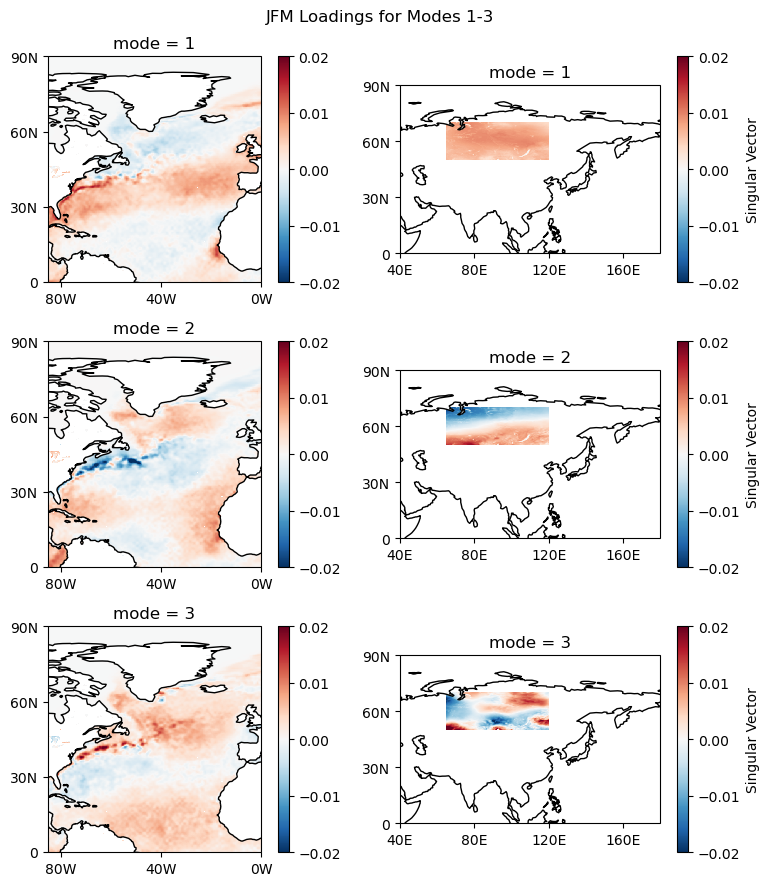

In [6]:
# Define the tick labels for x (longitude) and y (latitude)
x_tick_labels = ['40E', '80E', '120E', '160E']
y_tick_labels = ['0', '30N', '60N', '90N']
levels = np.linspace(-0.02, 0.02, 5)

kwargs1 = {'cmap':'RdBu_r','vmin':-0.02,'vmax':0.02}
kwargs2 = {'cmap':'RdBu_r','label': "Singular Vector",'vmin':-0.02,'vmax':0.02}

fig, ax = plt.subplots(3,2,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
for i in range(3):
    p1 = singular_vectors[0].sel(mode=i+1).plot(ax=ax[i,0], transform=PlateCarree(), add_colorbar=False, **kwargs1)
    p2 = singular_vectors[1].sel(mode=i+1).plot(ax=ax[i,1], transform=PlateCarree(), add_colorbar=False,**kwargs2)
    
    ax[i,1].set_xlim(40,180)
    ax[i,1].set_ylim(0,90)
    
    # # Add x and y ticks for latitude and longitude
    ax[i, 0].set_xticks(np.arange(-80,40,40))
    ax[i, 0].set_yticks(range(0,120,30))
    ax[i, 1].set_xticks(range(40,180,40))
    ax[i, 1].set_yticks(range(0,120,30))
 
    ax[i, 0].set_xticklabels(['80W', '40W', '0W'])
    ax[i, 0].set_yticklabels(y_tick_labels)
    ax[i, 1].set_xticklabels(['40E', '80E', '120E', '160E'])
    ax[i, 1].set_yticklabels(y_tick_labels)
    
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    
    p1.axes.coastlines()
    p2.axes.coastlines()
    # Ensure both plots are square
    ax[i, 0].set_aspect('equal', adjustable='box')
    ax[i, 1].set_aspect('equal', adjustable='box')

    cbar1 = fig.colorbar(p1, ax=ax[i, 0], orientation='vertical', ticks=levels)
    cbar2 = fig.colorbar(p2, ax=ax[i, 1], orientation='vertical', ticks=levels)
    
    # Set colorbar labels
    cbar2.set_label('Singular Vector')
plt.suptitle("JFM Loadings for Modes 1-3")
plt.tight_layout()

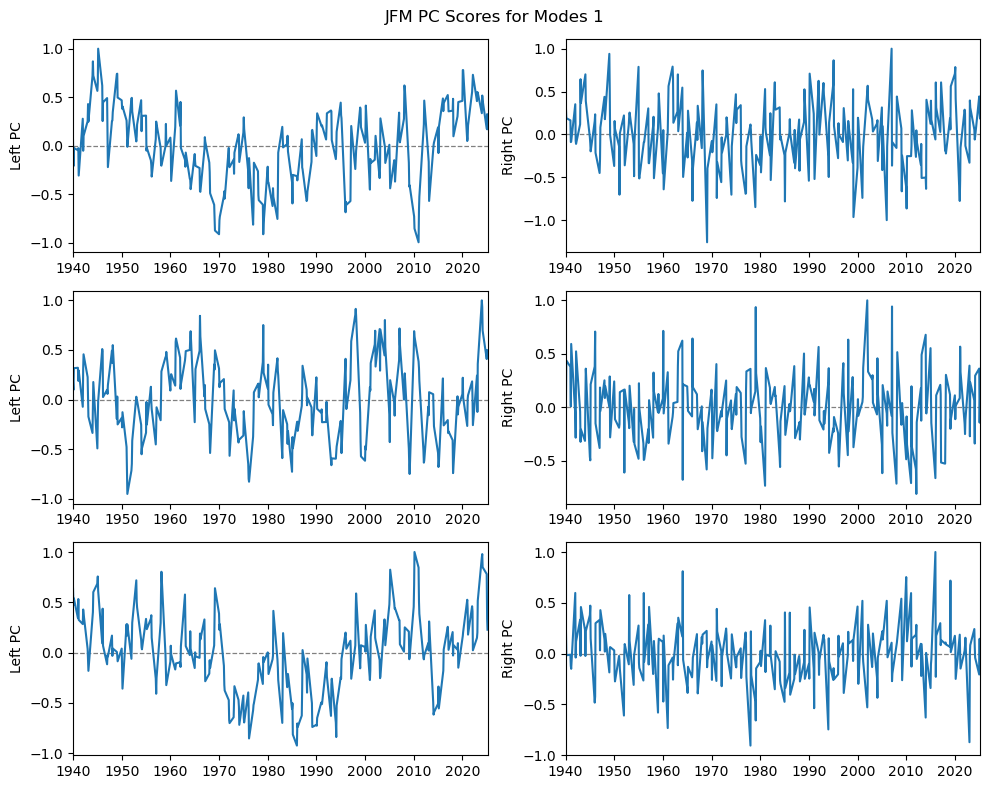

In [7]:
## Plotting
fig, ax = plt.subplots(3,2,figsize=(10, 8))

for i in range(3):
    ax[i,0].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    ax[i,1].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    
    normalized_pc1=scores[0].sel(mode=i+1)/scores[0].sel(mode=i+1).max()
    normalized_pc2=scores[1].sel(mode=i+1)/scores[1].sel(mode=i+1).max()
    ax[i,0].plot(scores[0].sel(mode=i+1).time,normalized_pc1)
    ax[i,1].plot(scores[1].sel(mode=i+1).time,normalized_pc2)
    
    # scores[0].sel(mode=i+1).plot(ax=ax[i,0])
    # scores[1].sel(mode=i+1).plot(ax=ax[i,1])
    ax[i,0].set_xlim(scores[0].time.min(),scores[0].time.max())
    ax[i,1].set_xlim(scores[0].time.min(),scores[0].time.max())
    years = mdates.YearLocator(10)  # Every 10 years
    ax[i,0].xaxis.set_major_locator(years)
    ax[i,1].xaxis.set_major_locator(years)
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("Left PC")
    ax[i,1].set_ylabel("Right PC")
    # ax[i,0].set_title("")
    # ax[i,1].set_title("")
plt.suptitle("JFM PC Scores for Modes 1")
plt.tight_layout()

(1.0, 8.0)

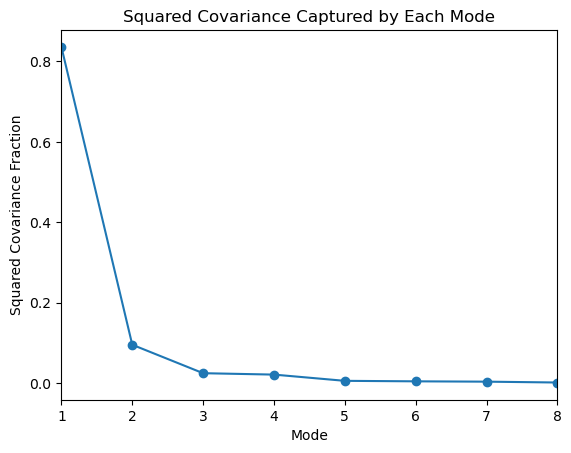

In [8]:
mca.squared_covariance_fraction().plot(marker='o')
plt.ylabel("Squared Covariance Fraction")
plt.xlabel("Mode")
plt.title("Squared Covariance Captured by Each Mode")
plt.xticks(np.arange(1,13))
plt.xlim(1,8)

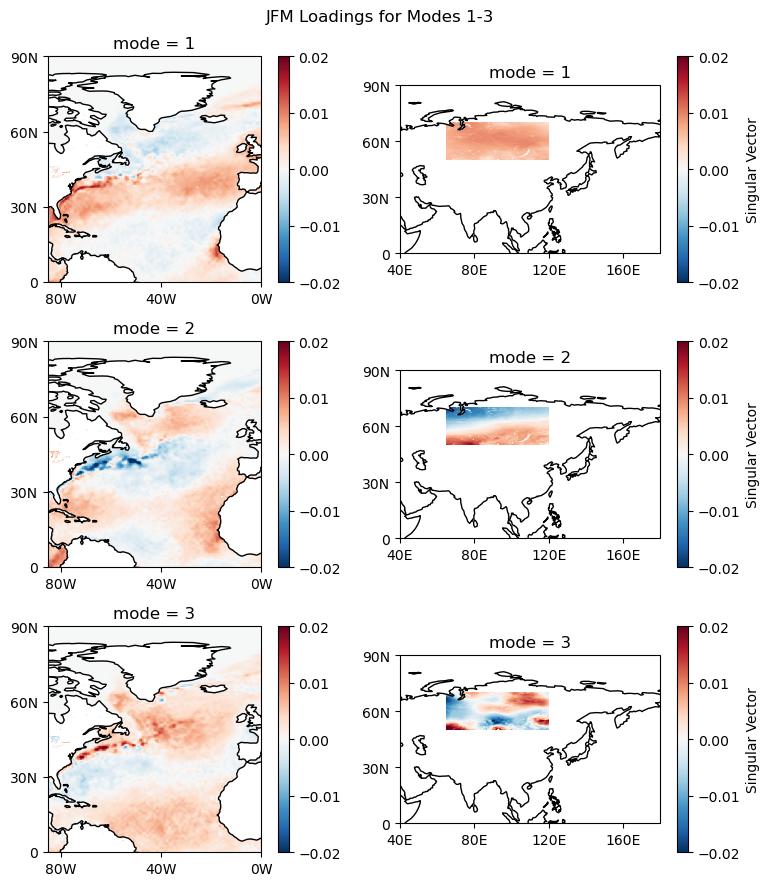

In [9]:
# Define the tick labels for x (longitude) and y (latitude)
x_tick_labels = ['40E', '80E', '120E', '160E']
y_tick_labels = ['0', '30N', '60N', '90N']
levels = np.linspace(-0.02, 0.02, 5)

kwargs1 = {'cmap':'RdBu_r','vmin':-0.02,'vmax':0.02}
kwargs2 = {'cmap':'RdBu_r','label': "Singular Vector",'vmin':-0.02,'vmax':0.02}

fig, ax = plt.subplots(3,2,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
for i in range(3):
    p1 = singular_vectors[0].sel(mode=i+1).plot(ax=ax[i,0], transform=PlateCarree(), add_colorbar=False, **kwargs1)
    p2 = singular_vectors[1].sel(mode=i+1).plot(ax=ax[i,1], transform=PlateCarree(), add_colorbar=False,**kwargs2)
    
    ax[i,1].set_xlim(40,180)
    ax[i,1].set_ylim(0,90)
    
    # # Add x and y ticks for latitude and longitude
    ax[i, 0].set_xticks(np.arange(-80,40,40))
    ax[i, 0].set_yticks(range(0,120,30))
    ax[i, 1].set_xticks(range(40,180,40))
    ax[i, 1].set_yticks(range(0,120,30))
 
    ax[i, 0].set_xticklabels(['80W', '40W', '0W'])
    ax[i, 0].set_yticklabels(y_tick_labels)
    ax[i, 1].set_xticklabels(['40E', '80E', '120E', '160E'])
    ax[i, 1].set_yticklabels(y_tick_labels)
    
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    
    p1.axes.coastlines()
    p2.axes.coastlines()
    # Ensure both plots are square
    ax[i, 0].set_aspect('equal', adjustable='box')
    ax[i, 1].set_aspect('equal', adjustable='box')

    cbar1 = fig.colorbar(p1, ax=ax[i, 0], orientation='vertical', ticks=levels)
    cbar2 = fig.colorbar(p2, ax=ax[i, 1], orientation='vertical', ticks=levels)
    
    # Set colorbar labels
    cbar2.set_label('Singular Vector')
plt.suptitle("JFM Loadings for Modes 1-3")
plt.tight_layout()

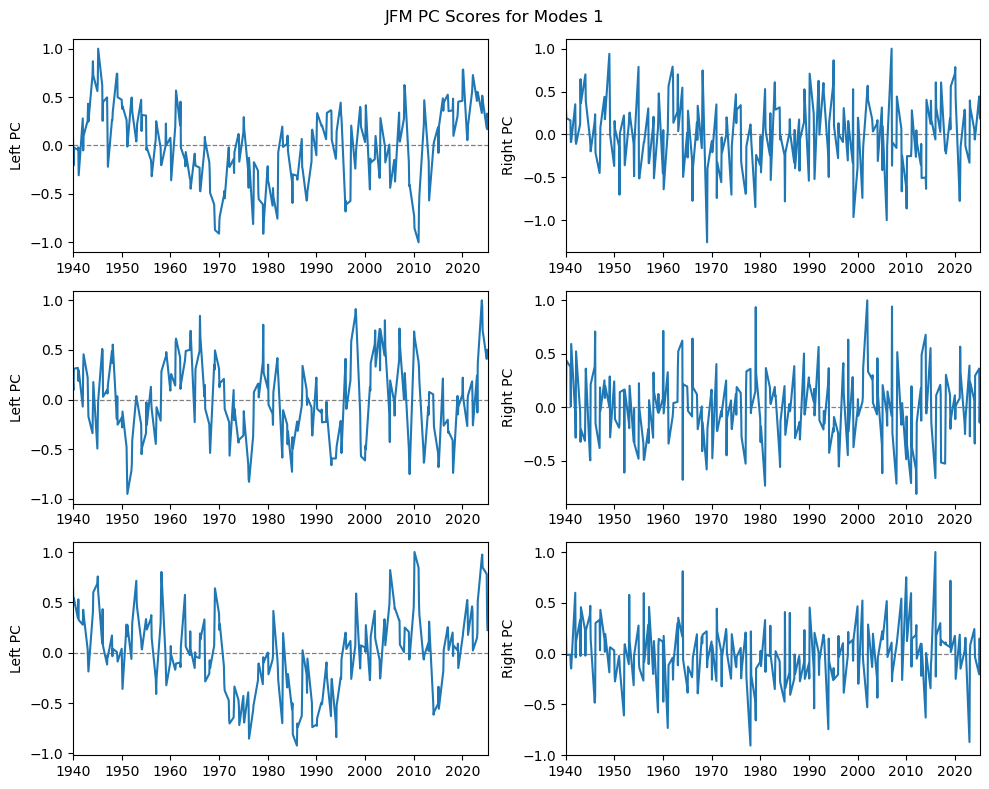

In [10]:
## Plotting
fig, ax = plt.subplots(3,2,figsize=(10, 8))

for i in range(3):
    ax[i,0].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    ax[i,1].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    
    normalized_pc1=scores[0].sel(mode=i+1)/scores[0].sel(mode=i+1).max()
    normalized_pc2=scores[1].sel(mode=i+1)/scores[1].sel(mode=i+1).max()
    ax[i,0].plot(scores[0].sel(mode=i+1).time,normalized_pc1)
    ax[i,1].plot(scores[1].sel(mode=i+1).time,normalized_pc2)
    
    # scores[0].sel(mode=i+1).plot(ax=ax[i,0])
    # scores[1].sel(mode=i+1).plot(ax=ax[i,1])
    ax[i,0].set_xlim(scores[0].time.min(),scores[0].time.max())
    ax[i,1].set_xlim(scores[0].time.min(),scores[0].time.max())
    years = mdates.YearLocator(10)  # Every 10 years
    ax[i,0].xaxis.set_major_locator(years)
    ax[i,1].xaxis.set_major_locator(years)
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("Left PC")
    ax[i,1].set_ylabel("Right PC")
    # ax[i,0].set_title("")
    # ax[i,1].set_title("")
plt.suptitle("JFM PC Scores for Modes 1")
plt.tight_layout()

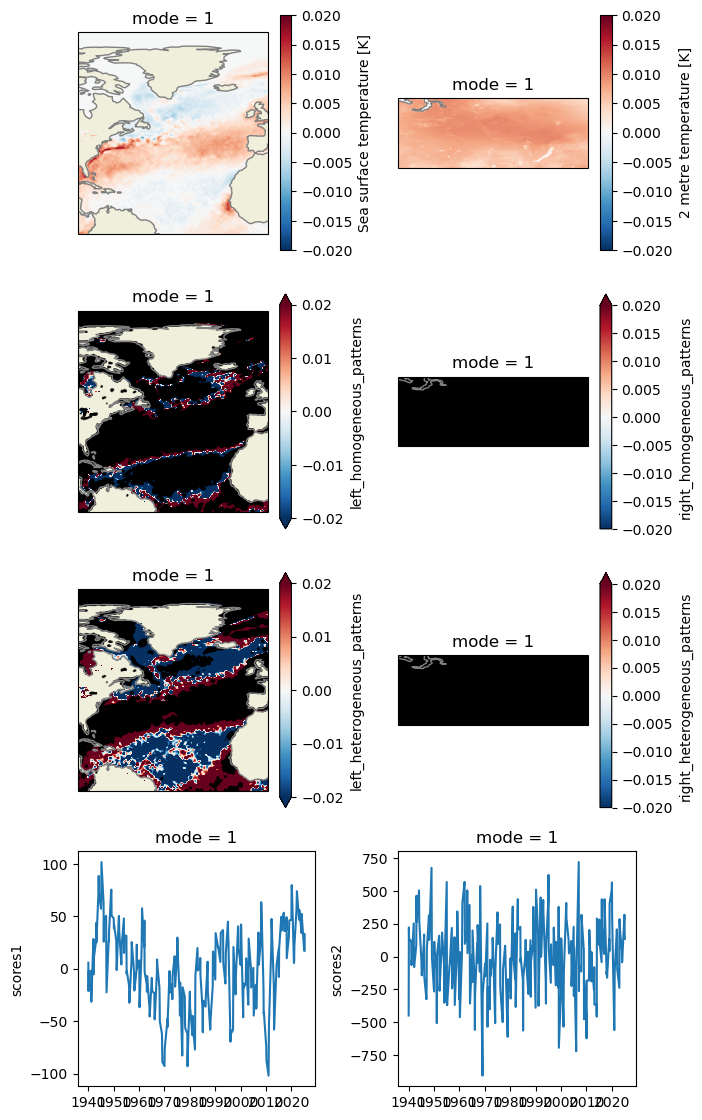

In [ ]:
lonlats = [
    np.meshgrid(pvals_hom[0].longitude.values, pvals_hom[0].latitude.values),
    np.meshgrid(pvals_hom[1].longitude.values, pvals_hom[1].latitude.values),
]
proj = [
    PlateCarree(),
    PlateCarree(),
]
# kwargs1 = {"cmap": "BrBG", "vmin": -0.05, "vmax": 0.05, "transform": PlateCarree()}
# kwargs2 = {"cmap": "RdBu", "vmin": -1, "vmax": 1, "transform": PlateCarree()}

kwargs1 = {'cmap':'RdBu_r','vmin':-0.02,'vmax':0.02}
kwargs2 = {'cmap':'RdBu_r','label': "Singular Vector",'vmin':-0.02,'vmax':0.02}

mode = 1

fig = plt.figure(figsize=(7, 14))
gs = GridSpec(5, 2)
ax1 = [fig.add_subplot(gs[0, i], projection=proj[i]) for i in range(2)]
ax2 = [fig.add_subplot(gs[1, i], projection=proj[i]) for i in range(2)]
ax3 = [fig.add_subplot(gs[2, i], projection=proj[i]) for i in range(2)]
ax4 = [fig.add_subplot(gs[3, i]) for i in range(2)]

for i, a in enumerate(ax1):
    singular_vectors[i].sel(mode=mode).plot(ax=a, **kwargs1)

for i, a in enumerate(ax2):
    hom_pats[i].sel(mode=mode).plot(ax=a, **kwargs2)
    a.scatter(
        lonlats[i][0],
        lonlats[i][1],
        hom_mask[i].sel(mode=mode).values * 0.5,
        color="k",
        alpha=0.5,
        transform=PlateCarree(),
    )
for i, a in enumerate(ax3):
    het_pats[i].sel(mode=mode).plot(ax=a, **kwargs2)
    a.scatter(
        lonlats[i][0],
        lonlats[i][1],
        het_mask[i].sel(mode=mode).values * 0.5,
        color="k",
        alpha=0.5,
        transform=PlateCarree(),
    )

for i, a in enumerate(ax4):
    scores[i].sel(mode=mode).plot(ax=a)
    a.set_xlabel("")


for a in np.ravel([ax1, ax2, ax3]):
    a.coastlines(color=".5")
    a.add_feature(LAND)

plt.tight_layout()

## MCA, months 2-4 FMA

In [ ]:
# Apply MCA over months 2-4 FMA
# remove linear trend and fill nan
ds_t2m = smg.preprocess_for_mca(ds, var='t2m', month_start=2, month_end=4, region=smg.siberia)
ds_sst = smg.preprocess_for_mca(ds, var='sst', month_start=2, month_end=4, region=smg.north_atlantic)

# scf, singular_vectors, scores, hom_pats, pvals_hom, het_pats, pvals_het = smg.stats_mca(ds_sst, ds_t2m, n_modes=3)

In [ ]:
mca = xe.cross.MCA(n_modes=12, standardize=False, use_coslat=True)
mca.fit(ds_sst, ds_t2m, dim="time")
mca.squared_covariance_fraction()

singular_vectors = mca.components()
scores = mca.scores()

hom_pats, pvals_hom = mca.homogeneous_patterns()
het_pats, pvals_het = mca.heterogeneous_patterns()

hom_mask = [values < 0.05 for values in pvals_hom]
het_mask = [values < 0.05 for values in pvals_het]

In [ ]:
# Define the tick labels for x (longitude) and y (latitude)
x_tick_labels = ['40E', '80E', '120E', '160E']
y_tick_labels = ['0', '30N', '60N', '90N']
levels = np.linspace(-0.02, 0.02, 5)

kwargs1 = {'cmap':'RdBu_r','vmin':-0.02,'vmax':0.02}
kwargs2 = {'cmap':'RdBu_r','label': "Singular Vector",'vmin':-0.02,'vmax':0.02}

fig, ax = plt.subplots(3,2,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
for i in range(3):
    p1 = singular_vectors[0].sel(mode=i+1).plot(ax=ax[i,0], transform=PlateCarree(), add_colorbar=False, **kwargs1)
    p2 = singular_vectors[1].sel(mode=i+1).plot(ax=ax[i,1], transform=PlateCarree(), add_colorbar=False,**kwargs2)
    
    ax[i,1].set_xlim(40,180)
    ax[i,1].set_ylim(0,90)
    
    # # Add x and y ticks for latitude and longitude
    ax[i, 0].set_xticks(np.arange(-80,40,40))
    ax[i, 0].set_yticks(range(0,120,30))
    ax[i, 1].set_xticks(range(40,180,40))
    ax[i, 1].set_yticks(range(0,120,30))
 
    ax[i, 0].set_xticklabels(['80W', '40W', '0W'])
    ax[i, 0].set_yticklabels(y_tick_labels)
    ax[i, 1].set_xticklabels(['40E', '80E', '120E', '160E'])
    ax[i, 1].set_yticklabels(y_tick_labels)
    
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    
    p1.axes.coastlines()
    p2.axes.coastlines()
    # Ensure both plots are square
    ax[i, 0].set_aspect('equal', adjustable='box')
    ax[i, 1].set_aspect('equal', adjustable='box')

    cbar1 = fig.colorbar(p1, ax=ax[i, 0], orientation='vertical', ticks=levels)
    cbar2 = fig.colorbar(p2, ax=ax[i, 1], orientation='vertical', ticks=levels)
    
    # Set colorbar labels
    cbar2.set_label('Singular Vector')
plt.suptitle("FMA Loadings for Modes 1-3")
plt.tight_layout()

In [ ]:
## Plotting
fig, ax = plt.subplots(3,2,figsize=(10, 8))

for i in range(3):
    ax[i,0].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    ax[i,1].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    
    normalized_pc1=scores[0].sel(mode=i+1)/scores[0].sel(mode=i+1).max()
    normalized_pc2=scores[1].sel(mode=i+1)/scores[1].sel(mode=i+1).max()
    ax[i,0].plot(scores[0].sel(mode=i+1).time,normalized_pc1)
    ax[i,1].plot(scores[1].sel(mode=i+1).time,normalized_pc2)
    
    # scores[0].sel(mode=i+1).plot(ax=ax[i,0])
    # scores[1].sel(mode=i+1).plot(ax=ax[i,1])
    ax[i,0].set_xlim(scores[0].time.min(),scores[0].time.max())
    ax[i,1].set_xlim(scores[0].time.min(),scores[0].time.max())
    years = mdates.YearLocator(10)  # Every 10 years
    ax[i,0].xaxis.set_major_locator(years)
    ax[i,1].xaxis.set_major_locator(years)
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("Left PC")
    ax[i,1].set_ylabel("Right PC")
    # ax[i,0].set_title("")
    # ax[i,1].set_title("")
plt.suptitle("FMA PC Scores for Modes 1-3")
plt.tight_layout()

In [ ]:
mca.squared_covariance_fraction().plot(marker='o')
plt.ylabel("Squared Covariance Fraction")
plt.xlabel("Mode")
plt.title("Squared Covariance Captured by Each Mode")
plt.xticks(np.arange(1,13))
plt.xlim(1,8)

## MCA, months 3-5 MAM

In [ ]:
# Apply MCA over months 3-5 MAM
ds_t2m = smg.preprocess_for_mca(ds, var='t2m', month_start=3, month_end=5, region=smg.siberia)
ds_sst = smg.preprocess_for_mca(ds, var='sst', month_start=3, month_end=5, region=smg.north_atlantic)

mca = xe.cross.MCA(n_modes=12, standardize=False, use_coslat=True)
mca.fit(ds_sst, ds_t2m, dim="time")
mca.squared_covariance_fraction()

singular_vectors = mca.components()
scores = mca.scores()

hom_pats, pvals_hom = mca.homogeneous_patterns()
het_pats, pvals_het = mca.heterogeneous_patterns()

hom_mask = [values < 0.05 for values in pvals_hom]
het_mask = [values < 0.05 for values in pvals_het]

## PLotting
# Define the tick labels for x (longitude) and y (latitude)
x_tick_labels = ['40E', '80E', '120E', '160E']
y_tick_labels = ['0', '30N', '60N', '90N']
levels = np.linspace(-0.02, 0.02, 5)

kwargs1 = {'cmap':'RdBu_r','vmin':-0.02,'vmax':0.02}
kwargs2 = {'cmap':'RdBu_r','label': "Singular Vector",'vmin':-0.02,'vmax':0.02}

fig, ax = plt.subplots(3,2,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
for i in range(3):
    p1 = singular_vectors[0].sel(mode=i+1).plot(ax=ax[i,0], transform=PlateCarree(), add_colorbar=False,**kwargs1)
    p2 = singular_vectors[1].sel(mode=i+1).plot(ax=ax[i,1], transform=PlateCarree(), add_colorbar=False,**kwargs2)
    
    ax[i,1].set_xlim(40,180)
    ax[i,1].set_ylim(0,90)
    
    # # Add x and y ticks for latitude and longitude
    ax[i, 0].set_xticks(np.arange(-80,40,40))
    ax[i, 0].set_yticks(range(0,120,30))
    ax[i, 1].set_xticks(range(40,180,40))
    ax[i, 1].set_yticks(range(0,120,30))
 
    ax[i, 0].set_xticklabels(['80W', '40W', '0W'])
    ax[i, 0].set_yticklabels(y_tick_labels)
    ax[i, 1].set_xticklabels(['40E', '80E', '120E', '160E'])
    ax[i, 1].set_yticklabels(y_tick_labels)
    
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    
    p1.axes.coastlines()
    p2.axes.coastlines()
    # Ensure both plots are square
    ax[i, 0].set_aspect('equal', adjustable='box')
    ax[i, 1].set_aspect('equal', adjustable='box')

    cbar1 = fig.colorbar(p1, ax=ax[i, 0], orientation='vertical', ticks=levels)
    cbar2 = fig.colorbar(p2, ax=ax[i, 1], orientation='vertical', ticks=levels)
    
    # Set colorbar labels
    cbar2.set_label('Singular Vector')
    
plt.suptitle("MCA for months 3-5")
plt.tight_layout()

In [ ]:
## Plotting
fig, ax = plt.subplots(3,2,figsize=(10, 8))

for i in range(3):
    ax[i,0].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    ax[i,1].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    
    normalized_pc1=scores[0].sel(mode=i+1)/scores[0].sel(mode=i+1).max()
    normalized_pc2=scores[1].sel(mode=i+1)/scores[1].sel(mode=i+1).max()
    ax[i,0].plot(scores[0].sel(mode=i+1).time,normalized_pc1)
    ax[i,1].plot(scores[1].sel(mode=i+1).time,normalized_pc2)
    
    # scores[0].sel(mode=i+1).plot(ax=ax[i,0])
    # scores[1].sel(mode=i+1).plot(ax=ax[i,1])
    ax[i,0].set_xlim(scores[0].time.min(),scores[0].time.max())
    ax[i,1].set_xlim(scores[0].time.min(),scores[0].time.max())
    years = mdates.YearLocator(10)  # Every 10 years
    ax[i,0].xaxis.set_major_locator(years)
    ax[i,1].xaxis.set_major_locator(years)
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("PC1")
    ax[i,1].set_ylabel("PC2")
    # ax[i,0].set_title("")
    # ax[i,1].set_title("")
plt.suptitle("MCA for months 3-5")
plt.tight_layout()

## MCA, months 4-6 AMJ

In [ ]:
# Apply MCA over months 4-6 AMJ
ds_t2m = smg.preprocess_for_mca(ds, var='t2m', month_start=3, month_end=6, region=smg.siberia)
ds_sst = smg.preprocess_for_mca(ds, var='sst', month_start=3, month_end=6, region=smg.north_atlantic)

mca = xe.cross.MCA(n_modes=12, standardize=False, use_coslat=True)
mca.fit(ds_sst, ds_t2m, dim="time")
mca.squared_covariance_fraction()

singular_vectors = mca.components()
scores = mca.scores()

hom_pats, pvals_hom = mca.homogeneous_patterns()
het_pats, pvals_het = mca.heterogeneous_patterns()

hom_mask = [values < 0.05 for values in pvals_hom]
het_mask = [values < 0.05 for values in pvals_het]

## PLotting
# Define the tick labels for x (longitude) and y (latitude)
x_tick_labels = ['40E', '80E', '120E', '160E']
y_tick_labels = ['0', '30N', '60N', '90N']
levels = np.linspace(-0.02, 0.02, 5)

kwargs1 = {'cmap':'RdBu_r','vmin':-0.02,'vmax':0.02}
kwargs2 = {'cmap':'RdBu_r','label': "Singular Vector",'vmin':-0.02,'vmax':0.02}

fig, ax = plt.subplots(3,2,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
for i in range(3):
    p1 = singular_vectors[0].sel(mode=i+1).plot(ax=ax[i,0], transform=PlateCarree(), add_colorbar=False, **kwargs1)
    p2 = singular_vectors[1].sel(mode=i+1).plot(ax=ax[i,1], transform=PlateCarree(), add_colorbar=False,**kwargs2)
    
    ax[i,1].set_xlim(40,180)
    ax[i,1].set_ylim(0,90)
    
    # # Add x and y ticks for latitude and longitude
    ax[i, 0].set_xticks(np.arange(-80,40,40))
    ax[i, 0].set_yticks(range(0,120,30))
    ax[i, 1].set_xticks(range(40,180,40))
    ax[i, 1].set_yticks(range(0,120,30))
 
    ax[i, 0].set_xticklabels(['80W', '40W', '0W'])
    ax[i, 0].set_yticklabels(y_tick_labels)
    ax[i, 1].set_xticklabels(['40E', '80E', '120E', '160E'])
    ax[i, 1].set_yticklabels(y_tick_labels)
    
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    
    p1.axes.coastlines()
    p2.axes.coastlines()
    # Ensure both plots are square
    ax[i, 0].set_aspect('equal', adjustable='box')
    ax[i, 1].set_aspect('equal', adjustable='box')

    cbar1 = fig.colorbar(p1, ax=ax[i, 0], orientation='vertical', ticks=levels)
    cbar2 = fig.colorbar(p2, ax=ax[i, 1], orientation='vertical', ticks=levels)
    
    # Set colorbar labels
    cbar2.set_label('Singular Vector')
    
plt.suptitle("MCA for months 4-6")
plt.tight_layout()

In [ ]:
## Plotting
fig, ax = plt.subplots(3,2,figsize=(10, 8))

for i in range(3):
    ax[i,0].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    ax[i,1].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    
    normalized_pc1=scores[0].sel(mode=i+1)/scores[0].sel(mode=i+1).max()
    normalized_pc2=scores[1].sel(mode=i+1)/scores[1].sel(mode=i+1).max()
    ax[i,0].plot(scores[0].sel(mode=i+1).time,normalized_pc1)
    ax[i,1].plot(scores[1].sel(mode=i+1).time,normalized_pc2)
    
    # scores[0].sel(mode=i+1).plot(ax=ax[i,0])
    # scores[1].sel(mode=i+1).plot(ax=ax[i,1])
    ax[i,0].set_xlim(scores[0].time.min(),scores[0].time.max())
    ax[i,1].set_xlim(scores[0].time.min(),scores[0].time.max())
    years = mdates.YearLocator(10)  # Every 10 years
    ax[i,0].xaxis.set_major_locator(years)
    ax[i,1].xaxis.set_major_locator(years)
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("PC1")
    ax[i,1].set_ylabel("PC2")
    # ax[i,0].set_title("")
    # ax[i,1].set_title("")
plt.suptitle("MCA for months 4-6")
plt.tight_layout()

# Left: North Atlantic, Right: Russia
## MCA, months 1-3 JFM

In [ ]:
path = "../../data0/yvu/ERA5/"
file = "era5_singlelvl_monthly.nc"
ds = xr.open_dataset(path+file)

# preprocess time format and apply land-sea mask to 2m temperature
ds['date']=pd.to_datetime(ds.date.values,format="%Y%m%d") # reformat date to time
ds = ds.rename({'date':'time'})
ds['t2m'] = ds.t2m.where(ds.lsm>0)
ds['t2m'] = ds.t2m * ds.lsm 

In [ ]:
# find a good region for "Russia"
min_lat = 50
max_lat = 80
min_lon = 30
max_lon = 180

# slice time/area of interest
fig, ax = plt.subplots(1,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
siberia_clim = ds.t2m.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))
siberia_clim.isel(time=1).plot(ax=ax)
ax.set_xlim(0,180)
ax.set_ylim(0,90)

# # Add x and y ticks for latitude and longitude
ax.set_xticks(np.arange(0,220,40))
ax.set_yticks(range(0,120,30))

# ax.set_xticklabels(['80W', '40W', '0W'])
ax.set_yticklabels(y_tick_labels)
# ax.set_xticklabels(['40E', '80E', '120E', '160E'])
ax.set_yticklabels(y_tick_labels)
ax.coastlines()
# Ensure both plots are square
ax.set_aspect('equal', adjustable='box')

In [ ]:
# Apply MCA over months 1-3 JFM
# remove linear trend and fill nan
min_lat = 50
max_lat = 80
min_lon = 30
max_lon = 180

ds_t2m = smg.preprocess(ds, var='t2m', month_start=1, month_end=3,min_lat=min_lat,max_lat=max_lat,min_lon=min_lon,max_lon=max_lon)
ds_sst = smg.preprocess(ds, var='sst', month_start=1, month_end=3, region=smg.north_atlantic)

# scf, scores, singular_vectors, hom_pats, pvals_hom, het_pats, pvals_het = smg.smg(ds_sst, ds_t2m, n_modes=3)

In [ ]:
mca = xe.cross.MCA(n_modes=12, standardize=False, use_coslat=True)
mca.fit(ds_sst, ds_t2m, dim="time")
mca.squared_covariance_fraction()

singular_vectors = mca.components()
scores = mca.scores()

hom_pats, pvals_hom = mca.homogeneous_patterns()
het_pats, pvals_het = mca.heterogeneous_patterns()

hom_mask = [values < 0.05 for values in pvals_hom]
het_mask = [values < 0.05 for values in pvals_het]

In [ ]:
# Define the tick labels for x (longitude) and y (latitude)
x_tick_labels = ['40E', '80E', '120E', '160E']
y_tick_labels = ['0', '30N', '60N', '90N']
levels = np.linspace(-0.02, 0.02, 5)

kwargs1 = {'cmap':'RdBu_r','vmin':-0.02,'vmax':0.02}
kwargs2 = {'cmap':'RdBu_r','label': "Singular Vector",'vmin':-0.02,'vmax':0.02}

fig, ax = plt.subplots(3,2,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
for i in range(3):
    p1 = singular_vectors[0].sel(mode=i+1).plot(ax=ax[i,0], transform=PlateCarree(), add_colorbar=False, **kwargs1)
    p2 = singular_vectors[1].sel(mode=i+1).plot(ax=ax[i,1], transform=PlateCarree(), add_colorbar=False,**kwargs2)
    
    ax[i,1].set_xlim(40,180)
    ax[i,1].set_ylim(0,90)
    
    # # Add x and y ticks for latitude and longitude
    ax[i, 0].set_xticks(np.arange(-80,40,40))
    ax[i, 0].set_yticks(range(0,120,30))
    ax[i, 1].set_xticks(range(40,180,40))
    ax[i, 1].set_yticks(range(0,120,30))
 
    ax[i, 0].set_xticklabels(['80W', '40W', '0W'])
    ax[i, 0].set_yticklabels(y_tick_labels)
    ax[i, 1].set_xticklabels(['40E', '80E', '120E', '160E'])
    ax[i, 1].set_yticklabels(y_tick_labels)
    
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    
    p1.axes.coastlines()
    p2.axes.coastlines()
    # Ensure both plots are square
    ax[i, 0].set_aspect('equal', adjustable='box')
    ax[i, 1].set_aspect('equal', adjustable='box')

    cbar1 = fig.colorbar(p1, ax=ax[i, 0], orientation='vertical', ticks=levels)
    cbar2 = fig.colorbar(p2, ax=ax[i, 1], orientation='vertical', ticks=levels)
    
    # Set colorbar labels
    cbar2.set_label('Singular Vector')
plt.suptitle("JFM Loadings for Modes 1-3")
plt.tight_layout()

In [ ]:
## Plotting
fig, ax = plt.subplots(3,2,figsize=(10, 8))

for i in range(3):
    ax[i,0].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    ax[i,1].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    
    normalized_pc1=scores[0].sel(mode=i+1)/scores[0].sel(mode=i+1).max()
    normalized_pc2=scores[1].sel(mode=i+1)/scores[1].sel(mode=i+1).max()
    ax[i,0].plot(scores[0].sel(mode=i+1).time,normalized_pc1)
    ax[i,1].plot(scores[1].sel(mode=i+1).time,normalized_pc2)
    
    # scores[0].sel(mode=i+1).plot(ax=ax[i,0])
    # scores[1].sel(mode=i+1).plot(ax=ax[i,1])
    ax[i,0].set_xlim(scores[0].time.min(),scores[0].time.max())
    ax[i,1].set_xlim(scores[0].time.min(),scores[0].time.max())
    years = mdates.YearLocator(10)  # Every 10 years
    ax[i,0].xaxis.set_major_locator(years)
    ax[i,1].xaxis.set_major_locator(years)
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("Left PC")
    ax[i,1].set_ylabel("Right PC")
    # ax[i,0].set_title("")
    # ax[i,1].set_title("")
plt.suptitle("JFM PC Scores for Modes 1")
plt.tight_layout()

In [ ]:
mca.squared_covariance_fraction().plot(marker='o')
plt.ylabel("Squared Covariance Fraction")
plt.xlabel("Mode")
plt.title("Squared Covariance Captured by Each Mode")
plt.xticks(np.arange(1,13))
plt.xlim(1,8)

## MCA, months 2-4 FMA

In [ ]:
# Apply MCA over months 2-4 FMA
# remove linear trend and fill nan
min_lat = 50
max_lat = 80
min_lon = 30
max_lon = 180

ds_t2m = smg.preprocess(ds, var='t2m', month_start=2, month_end=4,min_lat=min_lat,max_lat=max_lat,min_lon=min_lon,max_lon=max_lon)
ds_sst = smg.preprocess(ds, var='sst', month_start=2, month_end=4, region=smg.north_atlantic)

# scf, scores, singular_vectors, hom_pats, pvals_hom, het_pats, pvals_het = smg.smg(ds_sst, ds_t2m, n_modes=3)

In [ ]:
mca = xe.cross.MCA(n_modes=12, standardize=False, use_coslat=True)
mca.fit(ds_sst, ds_t2m, dim="time")
mca.squared_covariance_fraction()

singular_vectors = mca.components()
scores = mca.scores()

hom_pats, pvals_hom = mca.homogeneous_patterns()
het_pats, pvals_het = mca.heterogeneous_patterns()

hom_mask = [values < 0.05 for values in pvals_hom]
het_mask = [values < 0.05 for values in pvals_het]

In [ ]:
# Define the tick labels for x (longitude) and y (latitude)
x_tick_labels = ['40E', '80E', '120E', '160E']
y_tick_labels = ['0', '30N', '60N', '90N']
levels = np.linspace(-0.02, 0.02, 5)

kwargs1 = {'cmap':'RdBu_r','vmin':-0.02,'vmax':0.02}
kwargs2 = {'cmap':'RdBu_r','label': "Singular Vector",'vmin':-0.02,'vmax':0.02}

fig, ax = plt.subplots(3,2,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
for i in range(3):
    p1 = singular_vectors[0].sel(mode=i+1).plot(ax=ax[i,0], transform=PlateCarree(), add_colorbar=False, **kwargs1)
    p2 = singular_vectors[1].sel(mode=i+1).plot(ax=ax[i,1], transform=PlateCarree(), add_colorbar=False,**kwargs2)
    
    ax[i,1].set_xlim(40,180)
    ax[i,1].set_ylim(0,90)
    
    # # Add x and y ticks for latitude and longitude
    ax[i, 0].set_xticks(np.arange(-80,40,40))
    ax[i, 0].set_yticks(range(0,120,30))
    ax[i, 1].set_xticks(range(40,180,40))
    ax[i, 1].set_yticks(range(0,120,30))
 
    ax[i, 0].set_xticklabels(['80W', '40W', '0W'])
    ax[i, 0].set_yticklabels(y_tick_labels)
    ax[i, 1].set_xticklabels(['40E', '80E', '120E', '160E'])
    ax[i, 1].set_yticklabels(y_tick_labels)
    
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    
    p1.axes.coastlines()
    p2.axes.coastlines()
    # Ensure both plots are square
    ax[i, 0].set_aspect('equal', adjustable='box')
    ax[i, 1].set_aspect('equal', adjustable='box')

    cbar1 = fig.colorbar(p1, ax=ax[i, 0], orientation='vertical', ticks=levels)
    cbar2 = fig.colorbar(p2, ax=ax[i, 1], orientation='vertical', ticks=levels)
    
    # Set colorbar labels
    cbar2.set_label('Singular Vector')
plt.suptitle("FMA Loadings for Modes 1-3")
plt.tight_layout()

In [ ]:
## Plotting
fig, ax = plt.subplots(3,2,figsize=(10, 8))

for i in range(3):
    ax[i,0].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    ax[i,1].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    
    normalized_pc1=scores[0].sel(mode=i+1)/scores[0].sel(mode=i+1).max()
    normalized_pc2=scores[1].sel(mode=i+1)/scores[1].sel(mode=i+1).max()
    ax[i,0].plot(scores[0].sel(mode=i+1).time,normalized_pc1)
    ax[i,1].plot(scores[1].sel(mode=i+1).time,normalized_pc2)
    
    # scores[0].sel(mode=i+1).plot(ax=ax[i,0])
    # scores[1].sel(mode=i+1).plot(ax=ax[i,1])
    ax[i,0].set_xlim(scores[0].time.min(),scores[0].time.max())
    ax[i,1].set_xlim(scores[0].time.min(),scores[0].time.max())
    years = mdates.YearLocator(10)  # Every 10 years
    ax[i,0].xaxis.set_major_locator(years)
    ax[i,1].xaxis.set_major_locator(years)
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("Left PC")
    ax[i,1].set_ylabel("Right PC")
    # ax[i,0].set_title("")
    # ax[i,1].set_title("")
plt.suptitle("FMA PC Scores for Modes 1-3")
plt.tight_layout()

In [ ]:
mca.squared_covariance_fraction().plot(marker='o')
plt.ylabel("Squared Covariance Fraction")
plt.xlabel("Mode")
plt.title("Squared Covariance Captured by Each Mode")
plt.xticks(np.arange(1,13))
plt.xlim(1,8)

## MCA, months 3-5 MAM

In [ ]:
# Apply MCA over months 3-5 MAM
min_lat = 50
max_lat = 80
min_lon = 30
max_lon = 180

ds_t2m = smg.preprocess(ds, var='t2m', month_start=3, month_end=5,min_lat=min_lat,max_lat=max_lat,min_lon=min_lon,max_lon=max_lon)
ds_sst = smg.preprocess(ds, var='sst', month_start=3, month_end=5, region=smg.north_atlantic)

mca = xe.cross.MCA(n_modes=12, standardize=False, use_coslat=True)
mca.fit(ds_sst, ds_t2m, dim="time")
mca.squared_covariance_fraction()

singular_vectors = mca.components()
scores = mca.scores()

hom_pats, pvals_hom = mca.homogeneous_patterns()
het_pats, pvals_het = mca.heterogeneous_patterns()

hom_mask = [values < 0.05 for values in pvals_hom]
het_mask = [values < 0.05 for values in pvals_het]

## PLotting
# Define the tick labels for x (longitude) and y (latitude)
x_tick_labels = ['40E', '80E', '120E', '160E']
y_tick_labels = ['0', '30N', '60N', '90N']
levels = np.linspace(-0.02, 0.02, 5)

kwargs1 = {'cmap':'RdBu_r','vmin':-0.02,'vmax':0.02}
kwargs2 = {'cmap':'RdBu_r','label': "Singular Vector",'vmin':-0.02,'vmax':0.02}

fig, ax = plt.subplots(3,2,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
for i in range(3):
    p1 = singular_vectors[0].sel(mode=i+1).plot(ax=ax[i,0], transform=PlateCarree(), add_colorbar=False,**kwargs1)
    p2 = singular_vectors[1].sel(mode=i+1).plot(ax=ax[i,1], transform=PlateCarree(), add_colorbar=False,**kwargs2)
    
    ax[i,1].set_xlim(40,180)
    ax[i,1].set_ylim(0,90)
    
    # # Add x and y ticks for latitude and longitude
    ax[i, 0].set_xticks(np.arange(-80,40,40))
    ax[i, 0].set_yticks(range(0,120,30))
    ax[i, 1].set_xticks(range(40,180,40))
    ax[i, 1].set_yticks(range(0,120,30))
 
    ax[i, 0].set_xticklabels(['80W', '40W', '0W'])
    ax[i, 0].set_yticklabels(y_tick_labels)
    ax[i, 1].set_xticklabels(['40E', '80E', '120E', '160E'])
    ax[i, 1].set_yticklabels(y_tick_labels)
    
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    
    p1.axes.coastlines()
    p2.axes.coastlines()
    # Ensure both plots are square
    ax[i, 0].set_aspect('equal', adjustable='box')
    ax[i, 1].set_aspect('equal', adjustable='box')

    cbar1 = fig.colorbar(p1, ax=ax[i, 0], orientation='vertical', ticks=levels)
    cbar2 = fig.colorbar(p2, ax=ax[i, 1], orientation='vertical', ticks=levels)
    
    # Set colorbar labels
    cbar2.set_label('Singular Vector')
    
plt.suptitle("MCA for months 3-5")
plt.tight_layout()

In [ ]:
## Plotting
fig, ax = plt.subplots(3,2,figsize=(10, 8))

for i in range(3):
    ax[i,0].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    ax[i,1].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    
    normalized_pc1=scores[0].sel(mode=i+1)/scores[0].sel(mode=i+1).max()
    normalized_pc2=scores[1].sel(mode=i+1)/scores[1].sel(mode=i+1).max()
    ax[i,0].plot(scores[0].sel(mode=i+1).time,normalized_pc1)
    ax[i,1].plot(scores[1].sel(mode=i+1).time,normalized_pc2)
    
    # scores[0].sel(mode=i+1).plot(ax=ax[i,0])
    # scores[1].sel(mode=i+1).plot(ax=ax[i,1])
    ax[i,0].set_xlim(scores[0].time.min(),scores[0].time.max())
    ax[i,1].set_xlim(scores[0].time.min(),scores[0].time.max())
    years = mdates.YearLocator(10)  # Every 10 years
    ax[i,0].xaxis.set_major_locator(years)
    ax[i,1].xaxis.set_major_locator(years)
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("PC1")
    ax[i,1].set_ylabel("PC2")
    # ax[i,0].set_title("")
    # ax[i,1].set_title("")
plt.suptitle("MCA for months 3-5")
plt.tight_layout()

## MCA, months 4-6 AMJ

In [ ]:
# Apply MCA over months 4-6 AMJ
min_lat = 50
max_lat = 80
min_lon = 30
max_lon = 180
ds_t2m = smg.preprocess(ds, var='t2m', month_start=3, month_end=6,min_lat=min_lat,max_lat=max_lat,min_lon=min_lon,max_lon=max_lon)
ds_sst = smg.preprocess(ds, var='sst', month_start=3, month_end=6, region=smg.north_atlantic)

mca = xe.cross.MCA(n_modes=12, standardize=False, use_coslat=True)
mca.fit(ds_sst, ds_t2m, dim="time")
mca.squared_covariance_fraction()

singular_vectors = mca.components()
scores = mca.scores()

hom_pats, pvals_hom = mca.homogeneous_patterns()
het_pats, pvals_het = mca.heterogeneous_patterns()

hom_mask = [values < 0.05 for values in pvals_hom]
het_mask = [values < 0.05 for values in pvals_het]

## PLotting
# Define the tick labels for x (longitude) and y (latitude)
x_tick_labels = ['40E', '80E', '120E', '160E']
y_tick_labels = ['0', '30N', '60N', '90N']
levels = np.linspace(-0.02, 0.02, 5)

kwargs1 = {'cmap':'RdBu_r','vmin':-0.02,'vmax':0.02}
kwargs2 = {'cmap':'RdBu_r','label': "Singular Vector",'vmin':-0.02,'vmax':0.02}

fig, ax = plt.subplots(3,2,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
for i in range(3):
    p1 = singular_vectors[0].sel(mode=i+1).plot(ax=ax[i,0], transform=PlateCarree(), add_colorbar=False, **kwargs1)
    p2 = singular_vectors[1].sel(mode=i+1).plot(ax=ax[i,1], transform=PlateCarree(), add_colorbar=False,**kwargs2)
    
    ax[i,1].set_xlim(40,180)
    ax[i,1].set_ylim(0,90)
    
    # # Add x and y ticks for latitude and longitude
    ax[i, 0].set_xticks(np.arange(-80,40,40))
    ax[i, 0].set_yticks(range(0,120,30))
    ax[i, 1].set_xticks(range(40,180,40))
    ax[i, 1].set_yticks(range(0,120,30))
 
    ax[i, 0].set_xticklabels(['80W', '40W', '0W'])
    ax[i, 0].set_yticklabels(y_tick_labels)
    ax[i, 1].set_xticklabels(['40E', '80E', '120E', '160E'])
    ax[i, 1].set_yticklabels(y_tick_labels)
    
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    
    p1.axes.coastlines()
    p2.axes.coastlines()
    # Ensure both plots are square
    ax[i, 0].set_aspect('equal', adjustable='box')
    ax[i, 1].set_aspect('equal', adjustable='box')

    cbar1 = fig.colorbar(p1, ax=ax[i, 0], orientation='vertical', ticks=levels)
    cbar2 = fig.colorbar(p2, ax=ax[i, 1], orientation='vertical', ticks=levels)
    
    # Set colorbar labels
    cbar2.set_label('Singular Vector')
    
plt.suptitle("MCA for months 4-6")
plt.tight_layout()

In [ ]:
## Plotting
fig, ax = plt.subplots(3,2,figsize=(10, 8))

for i in range(3):
    ax[i,0].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    ax[i,1].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    
    normalized_pc1=scores[0].sel(mode=i+1)/scores[0].sel(mode=i+1).max()
    normalized_pc2=scores[1].sel(mode=i+1)/scores[1].sel(mode=i+1).max()
    ax[i,0].plot(scores[0].sel(mode=i+1).time,normalized_pc1)
    ax[i,1].plot(scores[1].sel(mode=i+1).time,normalized_pc2)
    
    # scores[0].sel(mode=i+1).plot(ax=ax[i,0])
    # scores[1].sel(mode=i+1).plot(ax=ax[i,1])
    ax[i,0].set_xlim(scores[0].time.min(),scores[0].time.max())
    ax[i,1].set_xlim(scores[0].time.min(),scores[0].time.max())
    years = mdates.YearLocator(10)  # Every 10 years
    ax[i,0].xaxis.set_major_locator(years)
    ax[i,1].xaxis.set_major_locator(years)
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("PC1")
    ax[i,1].set_ylabel("PC2")
    # ax[i,0].set_title("")
    # ax[i,1].set_title("")
plt.suptitle("MCA for months 4-6")
plt.tight_layout()

# Left: North Atlantic, Right: Eurasia
## MCA, months 1-3 JFM

In [ ]:
[str(x)+'E' for x in np.arange(0,220,40)]

In [ ]:
# find a good region for "Eurasia"
min_lat = 40
max_lat = 80
min_lon = 0
max_lon = 180

# slice time/area of interest
fig, ax = plt.subplots(1,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
siberia_clim = ds.t2m.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))
siberia_clim.isel(time=1).plot(ax=ax)
ax.set_xlim(0,180)
ax.set_ylim(0,90)

# # Add x and y ticks for latitude and longitude
ax.set_xticks(np.arange(0,180,40))
ax.set_yticks(range(0,120,30))
x_tick_labels = [str(x)+'E' for x in np.arange(0,180,40)]
y_tick_labels = [str(x)+'N' for x in range(0,120,30)]

ax.set_xticklabels(x_tick_labels)
ax.set_yticklabels(y_tick_labels)
ax.coastlines()
# Ensure both plots are square
ax.set_aspect('equal', adjustable='box')

In [ ]:
# Apply MCA over months 1-3 JFM
# remove linear trend and fill nan
min_lat = 40
max_lat = 80
min_lon = 0
max_lon = 180

ds_t2m = smg.preprocess(ds, var='t2m', month_start=1, month_end=3, region=smg.eurasia)
ds_sst = smg.preprocess(ds, var='sst', month_start=1, month_end=3, region=smg.north_atlantic)
# scf, scores, singular_vectors, hom_pats, pvals_hom, het_pats, pvals_het = smg.smg(ds_sst, ds_t2m, n_modes=3)

In [ ]:
mca = xe.cross.MCA(n_modes=12, standardize=False, use_coslat=True)
mca.fit(ds_sst, ds_t2m, dim="time")
mca.squared_covariance_fraction()

singular_vectors = mca.components(normalized=False)
scores = mca.scores(normalized=True)

hom_pats, pvals_hom = mca.homogeneous_patterns()
het_pats, pvals_het = mca.heterogeneous_patterns()

hom_mask = [values < 0.05 for values in pvals_hom]
het_mask = [values < 0.05 for values in pvals_het]

In [ ]:
mca.squared_covariance_fraction().plot(marker='o')
plt.ylabel("Squared Covariance Fraction")
plt.xlabel("Mode")
plt.title("Squared Covariance Captured by Each Mode")
plt.xticks(np.arange(1,13))
plt.xlim(1,8)

In [ ]:
# Define the tick labels for x (longitude) and y (latitude)
x_tick_labels = ['40E', '80E', '120E', '160E']
y_tick_labels = ['0', '30N', '60N', '90N']

kwargs1 = {'cmap':'RdBu_r','vmin':-5,'vmax':5}
kwargs2 = {'cmap':'RdBu_r','label': "Temperature [°C]",'vmin':-10,'vmax':10}

fig, ax = plt.subplots(3,2,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
for i in range(3):
    p1 = singular_vectors[0].sel(mode=i+1).plot(ax=ax[i,0], transform=PlateCarree(), add_colorbar=False, **kwargs1)
    p2 = singular_vectors[1].sel(mode=i+1).plot(ax=ax[i,1], transform=PlateCarree(), add_colorbar=False,**kwargs2)
    
    ax[i,1].set_xlim(40,180)
    ax[i,1].set_ylim(0,90)
    
    # # Add x and y ticks for latitude and longitude
    ax[i, 0].set_xticks(np.arange(-80,40,40))
    ax[i, 0].set_yticks(range(0,120,30))
    ax[i, 1].set_xticks(range(40,180,40))
    ax[i, 1].set_yticks(range(0,120,30))
 
    ax[i, 0].set_xticklabels(['80W', '40W', '0W'])
    ax[i, 0].set_yticklabels(y_tick_labels)
    ax[i, 1].set_xticklabels(['40E', '80E', '120E', '160E'])
    ax[i, 1].set_yticklabels(y_tick_labels)
    
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    
    p1.axes.coastlines()
    p2.axes.coastlines()
    # Ensure both plots are square
    ax[i, 0].set_aspect('equal', adjustable='box')
    ax[i, 1].set_aspect('equal', adjustable='box')

    cbar1 = fig.colorbar(p1, ax=ax[i, 0], orientation='vertical', ticks=np.linspace(-5, 5, 6))
    cbar2 = fig.colorbar(p2, ax=ax[i, 1], orientation='vertical', ticks=np.linspace(-10, 10, 6))
    
    # Set colorbar labels
    cbar2.set_label('Temperature [°C]')
plt.suptitle("SST vs 2m Temperature Loadings for JFM")
plt.tight_layout()
plt.savefig('2020eurasianheatwave-mca-jfm-loadings.png')

In [ ]:
scores[0].sel(mode=i+1)

In [ ]:
## Plotting
fig, ax = plt.subplots(3,2,figsize=(10, 8))

for i in range(3):
    ax[i,0].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    ax[i,1].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    
    normalized_pc1=scores[0].sel(mode=i+1)
    normalized_pc2=scores[1].sel(mode=i+1)
    ax[i,0].plot(scores[0].sel(mode=i+1).time,normalized_pc1,marker='o')
    ax[i,1].plot(scores[1].sel(mode=i+1).time,normalized_pc2,marker='o')
    
    ax[i,0].set_xlim(scores[0].time.min(),scores[0].time.max())
    ax[i,1].set_xlim(scores[0].time.min(),scores[0].time.max())
    years = mdates.YearLocator(5)  # Every 10 years
    ax[i,0].xaxis.set_major_locator(years)
    ax[i,1].xaxis.set_major_locator(years)
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("Mode "+str(i+1)+"\nSST")
    ax[i,1].set_ylabel("2m Temperature")
    ax[i,0].set_ylim(-0.5,0.5)
    ax[i,1].set_ylim(-0.5,0.5)
    ax[i,0].grid()
    ax[i,1].grid()
    # ax[i,0].set_title("")
    # ax[i,1].set_title("")
plt.suptitle("JFM Normalized PC Scores for Modes 1-3")
plt.tight_layout()
plt.savefig('2020eurasianheatwave-mca-jfm-pc-normalized.png')

In [ ]:
## Plotting
fig, ax = plt.subplots(3,2,figsize=(10, 8))

for i in range(3):
    ax[i,0].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    ax[i,1].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    
    normalized_pc1=scores[0].sel(mode=i+1)
    normalized_pc1=normalized_pc1.groupby('time.month')/normalized_pc1.groupby('time.month').map(standardize)
    normalized_pc2=scores[1].sel(mode=i+1)
    normalized_pc2=normalized_pc2.groupby('time.month')/normalized_pc2.groupby('time.month').map(standardize)
    ax[i,0].plot(scores[0].sel(mode=i+1).time,normalized_pc1,marker='o')
    ax[i,1].plot(scores[1].sel(mode=i+1).time,normalized_pc2,marker='o')
    
    # scores[0].sel(mode=i+1).plot(ax=ax[i,0])
    # scores[1].sel(mode=i+1).plot(ax=ax[i,1])
    ax[i,0].set_xlim(scores[0].time.min(),scores[0].time.max())
    ax[i,1].set_xlim(scores[0].time.min(),scores[0].time.max())
    years = mdates.YearLocator(5)  # Every 10 years
    ax[i,0].xaxis.set_major_locator(years)
    ax[i,1].xaxis.set_major_locator(years)
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("Mode "+str(i+1)+"\nSST")
    ax[i,1].set_ylabel("2m Temperature")
    ax[i,0].set_ylim(-3,3)
    ax[i,1].set_ylim(-3,3)
    ax[i,0].grid()
    ax[i,1].grid()
    # ax[i,0].set_title("")
    # ax[i,1].set_title("")
plt.suptitle("JFM Normalized PC Scores for Modes 1-3")
plt.tight_layout()
plt.savefig('2020eurasianheatwave-mca-jfm-pc-stdanom.png')

In [ ]:
scores[0].sel(mode=0+1).sel(time='2020')

## MCA, months 2-4 FMA

In [ ]:
# Apply MCA over months 2-4 FMA
# remove linear trend and fill nan
min_lat = 40
max_lat = 80
min_lon = 0
max_lon = 180

ds_t2m = smg.preprocess(ds, var='t2m', month_start=2, month_end=4,min_lat=min_lat,max_lat=max_lat,min_lon=min_lon,max_lon=max_lon)
ds_sst = smg.preprocess(ds, var='sst', month_start=2, month_end=4, region=smg.north_atlantic)

# scf, scores, singular_vectors, hom_pats, pvals_hom, het_pats, pvals_het = smg.smg(ds_sst, ds_t2m, n_modes=3)

In [ ]:
mca = xe.cross.MCA(n_modes=12, standardize=False, use_coslat=True)
mca.fit(ds_sst, ds_t2m, dim="time")
mca.squared_covariance_fraction()

singular_vectors = mca.components(normalized=False)
scores = mca.scores(normalized=True)

hom_pats, pvals_hom = mca.homogeneous_patterns()
het_pats, pvals_het = mca.heterogeneous_patterns()

hom_mask = [values < 0.05 for values in pvals_hom]
het_mask = [values < 0.05 for values in pvals_het]

In [ ]:
# Define the tick labels for x (longitude) and y (latitude)
x_tick_labels = ['40E', '80E', '120E', '160E']
y_tick_labels = ['0', '30N', '60N', '90N']

kwargs1 = {'cmap':'RdBu_r','vmin':-5,'vmax':5}
kwargs2 = {'cmap':'RdBu_r','label': "Temperature [°C]",'vmin':-10,'vmax':10}

fig, ax = plt.subplots(3,2,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
for i in range(3):
    p1 = singular_vectors[0].sel(mode=i+1).plot(ax=ax[i,0], transform=PlateCarree(), add_colorbar=False, **kwargs1)
    p2 = singular_vectors[1].sel(mode=i+1).plot(ax=ax[i,1], transform=PlateCarree(), add_colorbar=False,**kwargs2)
    
    ax[i,1].set_xlim(40,180)
    ax[i,1].set_ylim(0,90)
    
    # # Add x and y ticks for latitude and longitude
    ax[i, 0].set_xticks(np.arange(-80,40,40))
    ax[i, 0].set_yticks(range(0,120,30))
    ax[i, 1].set_xticks(range(40,180,40))
    ax[i, 1].set_yticks(range(0,120,30))
 
    ax[i, 0].set_xticklabels(['80W', '40W', '0W'])
    ax[i, 0].set_yticklabels(y_tick_labels)
    ax[i, 1].set_xticklabels(['40E', '80E', '120E', '160E'])
    ax[i, 1].set_yticklabels(y_tick_labels)
    
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    
    p1.axes.coastlines()
    p2.axes.coastlines()
    # Ensure both plots are square
    ax[i, 0].set_aspect('equal', adjustable='box')
    ax[i, 1].set_aspect('equal', adjustable='box')

    cbar1 = fig.colorbar(p1, ax=ax[i, 0], orientation='vertical', ticks=np.linspace(-5, 5, 6))
    cbar2 = fig.colorbar(p2, ax=ax[i, 1], orientation='vertical', ticks=np.linspace(-10, 10, 6))
    
    # Set colorbar labels
    cbar2.set_label('Temperature [°C]')
plt.suptitle("FMA Loadings for Modes 1-3")
plt.tight_layout()

In [ ]:
## Plotting
fig, ax = plt.subplots(3,2,figsize=(10, 8))

for i in range(3):
    ax[i,0].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    ax[i,1].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    
    normalized_pc1=scores[0].sel(mode=i+1)
    normalized_pc1=normalized_pc1.groupby('time.month')/normalized_pc1.groupby('time.month').map(standardize)
    normalized_pc2=scores[1].sel(mode=i+1)
    normalized_pc2=normalized_pc2.groupby('time.month')/normalized_pc2.groupby('time.month').map(standardize)
    ax[i,0].plot(scores[0].sel(mode=i+1).time,normalized_pc1,marker='o')
    ax[i,1].plot(scores[1].sel(mode=i+1).time,normalized_pc2,marker='o')
    
    # scores[0].sel(mode=i+1).plot(ax=ax[i,0])
    # scores[1].sel(mode=i+1).plot(ax=ax[i,1])
    ax[i,0].set_xlim(scores[0].time.min(),scores[0].time.max())
    ax[i,1].set_xlim(scores[0].time.min(),scores[0].time.max())
    years = mdates.YearLocator(5)  # Every 10 years
    ax[i,0].xaxis.set_major_locator(years)
    ax[i,1].xaxis.set_major_locator(years)
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("Mode "+str(i+1)+"\nSST")
    ax[i,1].set_ylabel("2m Temperature")
    ax[i,0].set_ylim(-3,3)
    ax[i,1].set_ylim(-3,3)
    ax[i,0].grid()
    ax[i,1].grid()
    # ax[i,0].set_title("")
    # ax[i,1].set_title("")
plt.suptitle("FMA PC Scores for Modes 1-3")
plt.tight_layout()

In [ ]:
mca.squared_covariance_fraction().plot(marker='o')
plt.ylabel("Squared Covariance Fraction")
plt.xlabel("Mode")
plt.title("Squared Covariance Captured by Each Mode")
plt.xticks(np.arange(1,13))
plt.xlim(1,8)

## MCA, months 3-5 MAM

In [ ]:
# Apply MCA over months 3-5 MAM
min_lat = 40
max_lat = 80
min_lon = 0
max_lon = 180

ds_t2m = smg.preprocess(ds, var='t2m', month_start=3, month_end=5,min_lat=min_lat,max_lat=max_lat,min_lon=min_lon,max_lon=max_lon)
ds_sst = smg.preprocess(ds, var='sst', month_start=3, month_end=5, region=smg.north_atlantic)

mca = xe.cross.MCA(n_modes=12, standardize=False, use_coslat=True)
mca.fit(ds_sst, ds_t2m, dim="time")
mca.squared_covariance_fraction()

singular_vectors = mca.components(normalized=False)
scores = mca.scores(normalized=True)

hom_pats, pvals_hom = mca.homogeneous_patterns()
het_pats, pvals_het = mca.heterogeneous_patterns()

hom_mask = [values < 0.05 for values in pvals_hom]
het_mask = [values < 0.05 for values in pvals_het]

## PLotting
# Define the tick labels for x (longitude) and y (latitude)
x_tick_labels = ['40E', '80E', '120E', '160E']
y_tick_labels = ['0', '30N', '60N', '90N']

kwargs1 = {'cmap':'RdBu_r','vmin':-5,'vmax':5}
kwargs2 = {'cmap':'RdBu_r','label': "Temperature [°C]",'vmin':-10,'vmax':10}

fig, ax = plt.subplots(3,2,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
for i in range(3):
    p1 = singular_vectors[0].sel(mode=i+1).plot(ax=ax[i,0], transform=PlateCarree(), add_colorbar=False, **kwargs1)
    p2 = singular_vectors[1].sel(mode=i+1).plot(ax=ax[i,1], transform=PlateCarree(), add_colorbar=False,**kwargs2)
    
    ax[i,1].set_xlim(40,180)
    ax[i,1].set_ylim(0,90)
    
    # # Add x and y ticks for latitude and longitude
    ax[i, 0].set_xticks(np.arange(-80,40,40))
    ax[i, 0].set_yticks(range(0,120,30))
    ax[i, 1].set_xticks(range(40,180,40))
    ax[i, 1].set_yticks(range(0,120,30))
 
    ax[i, 0].set_xticklabels(['80W', '40W', '0W'])
    ax[i, 0].set_yticklabels(y_tick_labels)
    ax[i, 1].set_xticklabels(['40E', '80E', '120E', '160E'])
    ax[i, 1].set_yticklabels(y_tick_labels)
    
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    
    p1.axes.coastlines()
    p2.axes.coastlines()
    # Ensure both plots are square
    ax[i, 0].set_aspect('equal', adjustable='box')
    ax[i, 1].set_aspect('equal', adjustable='box')

    cbar1 = fig.colorbar(p1, ax=ax[i, 0], orientation='vertical', ticks=np.linspace(-5, 5, 6))
    cbar2 = fig.colorbar(p2, ax=ax[i, 1], orientation='vertical', ticks=np.linspace(-10, 10, 6))
    
    # Set colorbar labels
    cbar2.set_label('Temperature [°C]')
    
plt.suptitle("MCA for months 3-5")
plt.tight_layout()

In [ ]:
## Plotting
fig, ax = plt.subplots(3,2,figsize=(10, 8))

for i in range(3):
    ax[i,0].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    ax[i,1].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    
    normalized_pc1=scores[0].sel(mode=i+1)
    normalized_pc1=normalized_pc1.groupby('time.month')/normalized_pc1.groupby('time.month').map(standardize)
    normalized_pc2=scores[1].sel(mode=i+1)
    normalized_pc2=normalized_pc2.groupby('time.month')/normalized_pc2.groupby('time.month').map(standardize)
    ax[i,0].plot(scores[0].sel(mode=i+1).time,normalized_pc1,marker='o')
    ax[i,1].plot(scores[1].sel(mode=i+1).time,normalized_pc2,marker='o')
    
    # scores[0].sel(mode=i+1).plot(ax=ax[i,0])
    # scores[1].sel(mode=i+1).plot(ax=ax[i,1])
    ax[i,0].set_xlim(scores[0].time.min(),scores[0].time.max())
    ax[i,1].set_xlim(scores[0].time.min(),scores[0].time.max())
    years = mdates.YearLocator(5)  # Every 10 years
    ax[i,0].xaxis.set_major_locator(years)
    ax[i,1].xaxis.set_major_locator(years)
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("Mode "+str(i+1)+"\nSST")
    ax[i,1].set_ylabel("2m Temperature")
    ax[i,0].set_ylim(-3,3)
    ax[i,1].set_ylim(-3,3)
    ax[i,0].grid()
    ax[i,1].grid()
    # ax[i,0].set_title("")
    # ax[i,1].set_title("")
plt.suptitle("MAM PC Scores for Modes 1-3")
plt.tight_layout()

## MCA, months 4-6 AMJ

In [ ]:
# Apply MCA over months 4-6 AMJ
min_lat = 40
max_lat = 80
min_lon = 0
max_lon = 180
ds_t2m = smg.preprocess(ds, var='t2m', month_start=3, month_end=6,min_lat=min_lat,max_lat=max_lat,min_lon=min_lon,max_lon=max_lon)
ds_sst = smg.preprocess(ds, var='sst', month_start=3, month_end=6, region=smg.north_atlantic)

mca = xe.cross.MCA(n_modes=12, standardize=False, use_coslat=True)
mca.fit(ds_sst, ds_t2m, dim="time")
mca.squared_covariance_fraction()

singular_vectors = mca.components(normalized=False)
scores = mca.scores(normalized=True)

hom_pats, pvals_hom = mca.homogeneous_patterns()
het_pats, pvals_het = mca.heterogeneous_patterns()

hom_mask = [values < 0.05 for values in pvals_hom]
het_mask = [values < 0.05 for values in pvals_het]

## Plotting
# Define the tick labels for x (longitude) and y (latitude)
x_tick_labels = ['40E', '80E', '120E', '160E']
y_tick_labels = ['0', '30N', '60N', '90N']

kwargs1 = {'cmap':'RdBu_r','vmin':-5,'vmax':5}
kwargs2 = {'cmap':'RdBu_r','label': "Temperature [°C]",'vmin':-10,'vmax':10}

fig, ax = plt.subplots(3,2,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
for i in range(3):
    p1 = singular_vectors[0].sel(mode=i+1).plot(ax=ax[i,0], transform=PlateCarree(), add_colorbar=False, **kwargs1)
    p2 = singular_vectors[1].sel(mode=i+1).plot(ax=ax[i,1], transform=PlateCarree(), add_colorbar=False,**kwargs2)
    
    ax[i,1].set_xlim(40,180)
    ax[i,1].set_ylim(0,90)
    
    # # Add x and y ticks for latitude and longitude
    ax[i, 0].set_xticks(np.arange(-80,40,40))
    ax[i, 0].set_yticks(range(0,120,30))
    ax[i, 1].set_xticks(range(40,180,40))
    ax[i, 1].set_yticks(range(0,120,30))
 
    ax[i, 0].set_xticklabels(['80W', '40W', '0W'])
    ax[i, 0].set_yticklabels(y_tick_labels)
    ax[i, 1].set_xticklabels(['40E', '80E', '120E', '160E'])
    ax[i, 1].set_yticklabels(y_tick_labels)
    
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    
    p1.axes.coastlines()
    p2.axes.coastlines()
    # Ensure both plots are square
    ax[i, 0].set_aspect('equal', adjustable='box')
    ax[i, 1].set_aspect('equal', adjustable='box')

    cbar1 = fig.colorbar(p1, ax=ax[i, 0], orientation='vertical', ticks=np.linspace(-5, 5, 6))
    cbar2 = fig.colorbar(p2, ax=ax[i, 1], orientation='vertical', ticks=np.linspace(-10, 10, 6))
    
    # Set colorbar labels
    cbar2.set_label('Temperature [°C]')
    
plt.suptitle("MCA for months 4-6")
plt.tight_layout()

In [ ]:
## Plotting
fig, ax = plt.subplots(3,2,figsize=(10, 8))

for i in range(3):
    ax[i,0].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    ax[i,1].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    
    normalized_pc1=scores[0].sel(mode=i+1)
    normalized_pc1=normalized_pc1.groupby('time.month')/normalized_pc1.groupby('time.month').map(standardize)
    normalized_pc2=scores[1].sel(mode=i+1)
    normalized_pc2=normalized_pc2.groupby('time.month')/normalized_pc2.groupby('time.month').map(standardize)
    ax[i,0].plot(scores[0].sel(mode=i+1).time,normalized_pc1,marker='o')
    ax[i,1].plot(scores[1].sel(mode=i+1).time,normalized_pc2,marker='o')
    
    # scores[0].sel(mode=i+1).plot(ax=ax[i,0])
    # scores[1].sel(mode=i+1).plot(ax=ax[i,1])
    ax[i,0].set_xlim(scores[0].time.min(),scores[0].time.max())
    ax[i,1].set_xlim(scores[0].time.min(),scores[0].time.max())
    years = mdates.YearLocator(5)  # Every 10 years
    ax[i,0].xaxis.set_major_locator(years)
    ax[i,1].xaxis.set_major_locator(years)
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("Mode "+str(i+1)+"\nSST")
    ax[i,1].set_ylabel("2m Temperature")
    ax[i,0].set_ylim(-3,3)
    ax[i,1].set_ylim(-3,3)
    ax[i,0].grid()
    ax[i,1].grid()
    # ax[i,0].set_title("")
    # ax[i,1].set_title("")
plt.suptitle("AMJ PC Scores for Modes 1-3")
plt.tight_layout()